In [35]:
import requests
import os
import pandas as pd
from openai import OpenAI
from PIL import Image
import time

### Download discount newsletter

In [10]:
def download_image(page_number):
    page_number = f"0{page_number}" if page_number < 10 else page_number
    image_url = f"https://images.biedronka.cloud/api/v1/cdn-cgi/r2/leaflet-prod/images/2025_ROK/2025_FOOD/2025_FOOD_T05/2025_FOOD_T05B/2025_FOOD_T05B_PODSTAWA/2025_FOOD_T05_B_PODSTAWA_P{page_number}_3xutgygc02.png?fmt=webp&qlt=90,1" 
    local_file = os.path.join("data", f"page_{page_number}.webp")
    img_data = requests.get(image_url).content
    with open(local_file, 'wb') as handler:
        handler.write(img_data)

In [15]:
number_of_pages = 33

for page_number in range(10, number_of_pages):
    download_image(page_number)

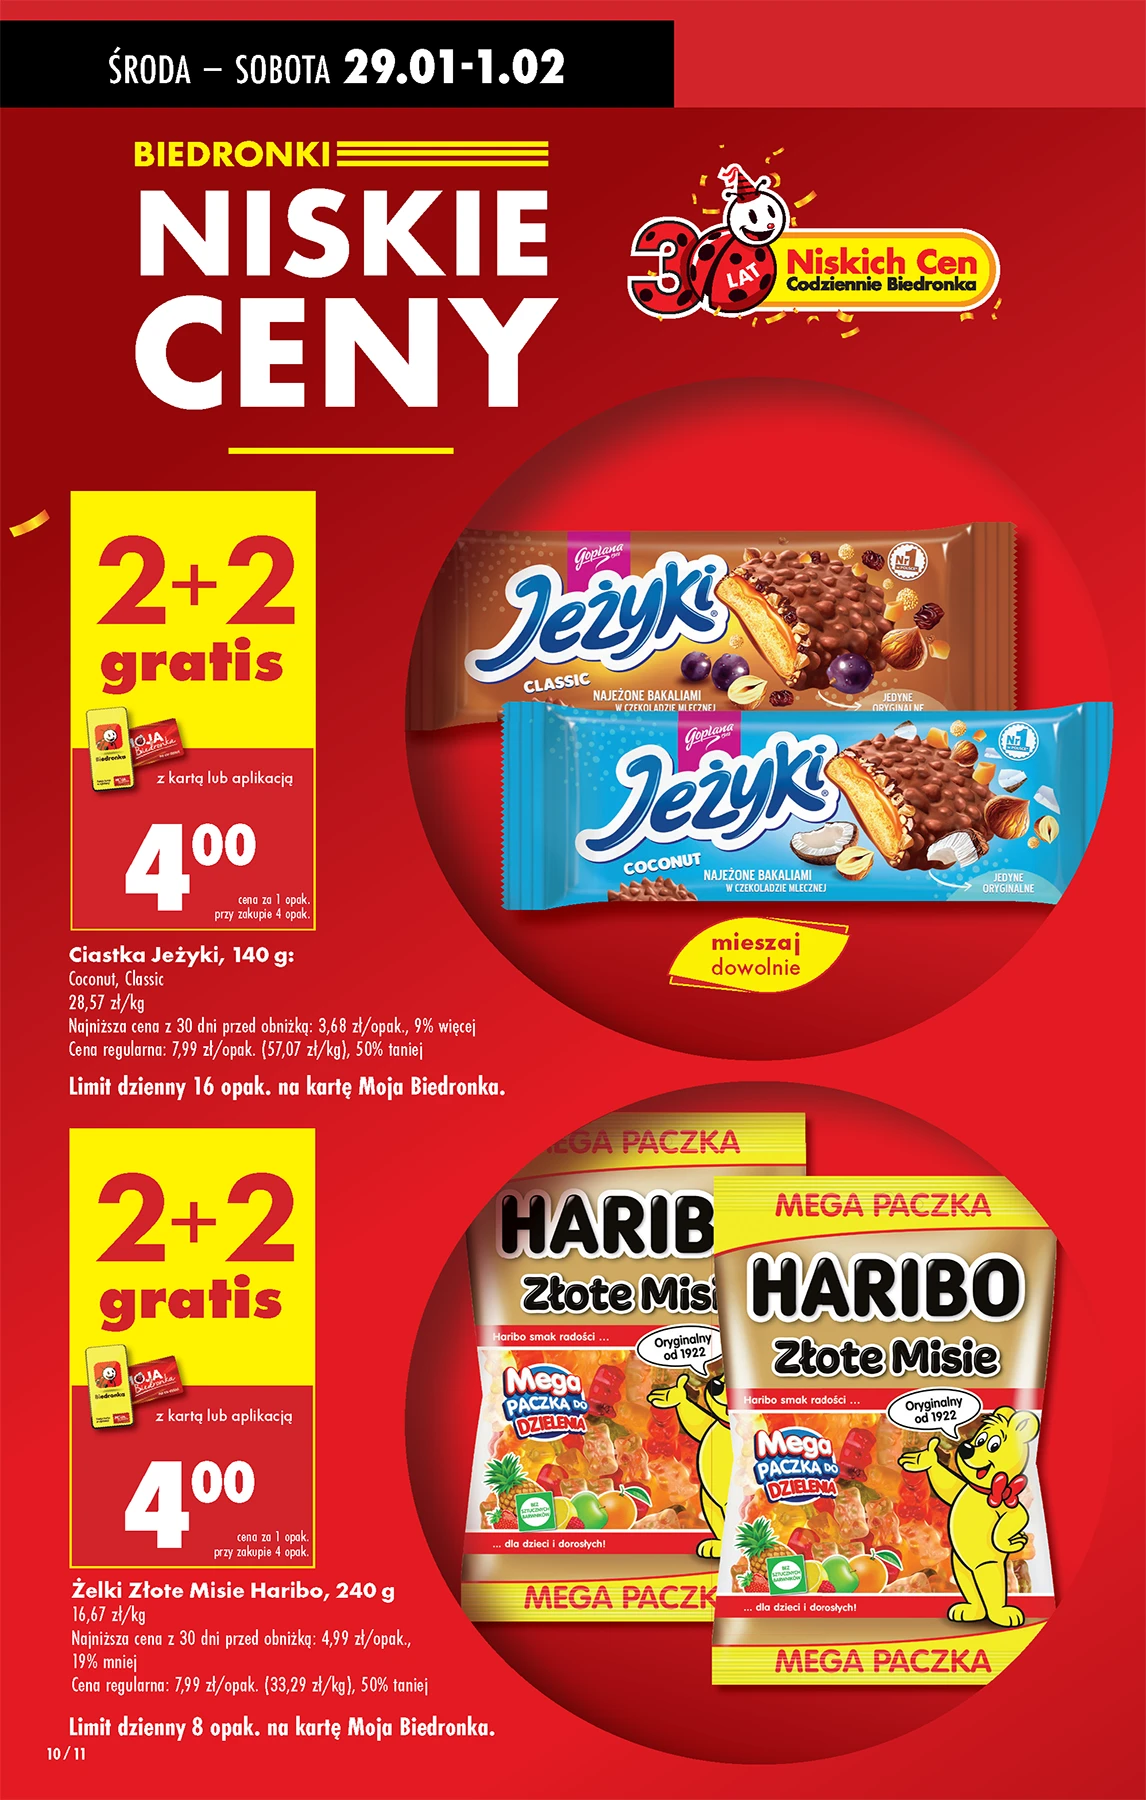

In [14]:
im = Image.open("data/page_10.webp").convert("RGB")
im

In [27]:
categories = ["owoce", "warzywa", "mięso", "ryby i owoce morza", "pieczywo", "kasze i makarony", "nabiał",
              "napoje", "alkohole", "słodycze",
              "kosmetyki", "chemia domowa"]

format = """{"article": str,
  "category": str,
  "price": str,
  "discount": str,
  "discount_condition": "str"
}"""

In [28]:
format

'{"article": str,\n  "category": str,\n  "price": str,\n  "discount": str,\n  "discount_condition": "str"\n}'

In [31]:
system_prompt = f"""
language: polski
wyciągnij z podanej grafiki wszystkie artykuły wraz z ich ceną, warunkami promocji oraz kategorią z podanej listy: {categories}.
Pole ceny wypełnij tak, jakby podana promocja była spełniona.
Niektóre promocje mogą mieć złożone warunki promocji, tak jak w przykładach poniżej:
"2+1 gratis" = promocja będzie działać przy zakupie 3 produktów. W takim przypadku płacę za 2 prdukty a trzeci otrzymuję za 0 zł.
"drugi produkt za 1 zł" = promocja będzie działać tylko przy zakupie 2 produktów. W takim przypadku płacę za 1 produkt pełną cenę, za drugi 1 zł.
w niektórych przypadkach originalna cena jest przekreślona i podana cena jest ceną promocyjną.
Zwróć odpowiedź jako listę obiektów o zadanym formacie:\n{format}
"""
print(system_prompt)



language: polski
wyciągnij z podanej grafiki wszystkie artykuły wraz z ich ceną, warunkami promocji oraz kategorią z podanej listy: ['owoce', 'warzywa', 'mięso', 'ryby i owoce morza', 'pieczywo', 'kasze i makarony', 'nabiał', 'napoje', 'alkohole', 'słodycze', 'kosmetyki', 'chemia domowa'].
Pole ceny wypełnij tak, jakby podana promocja była spełniona.
Niektóre promocje mogą mieć złożone warunki promocji, tak jak w przykładach poniżej:
"2+1 gratis" = promocja będzie działać przy zakupie 3 produktów. W takim przypadku płacę za 2 prdukty a trzeci otrzymuję za 0 zł.
"drugi produkt za 1 zł" = promocja będzie działać tylko przy zakupie 2 produktów. W takim przypadku płacę za 1 produkt pełną cenę, za drugi 1 zł.
w niektórych przypadkach originalna cena jest przekreślona i podana cena jest ceną promocyjną.
Zwróć odpowiedź jako listę obiektów o zadanym formacie:
{"article": str,
  "category": str,
  "price": str,
  "discount": str,
  "discount_condition": "str"
}



In [33]:
page_number = "13"
image_url = f"https://images.biedronka.cloud/api/v1/cdn-cgi/r2/leaflet-prod/images/2025_ROK/2025_FOOD/2025_FOOD_T05/2025_FOOD_T05B/2025_FOOD_T05B_PODSTAWA/2025_FOOD_T05_B_PODSTAWA_P{page_number}_3xutgygc02.png?fmt=webp&qlt=90,1" 

user_prompt = f"To jest link do grafiki: {image_url}"
image_url

'https://images.biedronka.cloud/api/v1/cdn-cgi/r2/leaflet-prod/images/2025_ROK/2025_FOOD/2025_FOOD_T05/2025_FOOD_T05B/2025_FOOD_T05B_PODSTAWA/2025_FOOD_T05_B_PODSTAWA_P13_3xutgygc02.png?fmt=webp&qlt=90,1'

In [ ]:
#response_format
#extra_headers: 'Headers | None' = None,
#    extra_query: 'Query | None' = None,
#    extra_body: 'Body | None' = None,

In [34]:
client = OpenAI(api_key="<DeepSeek API Key>", base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ],
    stream=False
)

print(response.choices[0].message.content)

AuthenticationError: Error code: 401 - {'error': {'message': 'Authentication Fails (no such user)', 'type': 'authentication_error', 'param': None, 'code': 'invalid_request_error'}}

In [ ]:
 = []

try:
    response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ],
    stream=False)
    new_items = eval(response.choices[0].message.content)
    article_list.extend(new_items)
except Exception as e:
    print(e)

In [ ]:
articles_df = pd.Dataframe.from_records(article_list)
articles_df

In [ ]:
articles_df = articles_df[~articles_df["category".isin([ "napoje", "alkohole", "słodycze", "kosmetyki", "chemia domowa"])]]

## add filtering based on discount.
## if price availiabe, add price tracking